In [1]:
#This script is used to process original AIRS and TES water isotope data.
#It will read in the data and interpolate them onto 2-deg grids, 5-day time interval.
#It will calculate the pressure-weighted multiple layer delta_D
#use TES data for example (daily data saved on monthly file)

In [10]:
#load modules needed
import numpy as np
import xarray as xr
from scipy.interpolate import griddata

In [4]:
#test single month [from the free atmos version]
te1=xr.open_dataset('/change to your path/TES-Aura_L2-HDO-Nadir_2006-04_v006_Litev01.00.nc')

In [5]:
#interpolation grids preparation
xi = np.arange(te1.Longitude.min(), te1.Longitude.max(), 2)
yi = np.arange(te1.Latitude.max(), te1.Latitude.min(), -2)  
lons,lats=np.meshgrid(xi,yi)
t =np.arange(1,366+5,5)
rc=3.11*10**(-4)
md=[0,31,28,31,30,31,30,31,31,30,31,30]
mdl=[0,31,29,31,30,31,30,31,31,30,31,30]

In [6]:
#check levels
psl=te1.Grid_Pressure[0:10]#the first 10 layers

In [8]:
#read in the data (loop can be used for a whole year with 73 5-day intervales)
lof_fw=[[]]*73  
laf_fw=[[]]*73 
pf_fw=[[]]*73#pressure
dtf_fw=[[]]*73#delta_D
qf_fw=[[]]*73#q
#real loop test for FREE atmosphere global with pressure weighted
for mn in range(4,5):#test for April, if run for the whole year, it should range from (1,13)
    mon=str(mn)
    ##########################################################################################
    #this loop can be used if you want to read in multiple data files
    #if mn<10:
        #infi='/change to your path/TES-Aura_L2-HDO-Nadir_*'+'0'+mon+'_v006_Litev01.00.nc'
    #else:
        #infi='/change to your path/TES-Aura_L2-HDO-Nadir_*'+mon+'_v006_Litev01.00.nc'
    #print(infi)
    #infi2=glob.glob(infi)
    #print(infi2)
    #for n in range(np.shape(infi2)[0]):
        #print(infi2[n])
        #te1=xr.open_dataset(infi2[n])
    ##########################################################################################
    te1=xr.open_dataset('/change to your path/TES-Aura_L2-HDO-Nadir_2006-04_v006_Litev01.00.nc')
    ad1=te1.Species[:,0:10]#volumn mixing ratio of HDO (17 levels)
    ao1=te1.Species[:,0+17:10+17]#volumn mixing ratio of H2O (17 levels)
    for i in range(ad1.shape[0]):
        qi=te1.SpeciesRetrievalQuality[i]#quality
        ci=te1.AverageCloudEffOpticalDepth[i]#cloud impact
        fi=te1.DegreesOfFreedomForSignal[i]#degree of freedom (sampling)
        r1=ad1[i,:]
        r2=ao1[i,:]
        cn1=np.count_nonzero(r1==-999.)#check missing value
        cn2=np.count_nonzero(r2==-999.)
        if cn1<10 and cn2<10 and ci<0.4 and fi>1. and qi==1:#quality control
            rtf=[]
            qtf=[]
            lof=[]
            laf=[]
            ptf=[]
            for j in range(2,8):#need 908-510hPa
                if r1[j]!=-999. and r2[j]!=-999.:
                    rtv=1000*(r1[j]/r2[j]-rc)/rc
                    rtf=np.append(rtf,rtv)
                    qtf=np.append(qtf,r2[j])
                    ptf=np.append(ptf,psl[j])
                    lof=np.append(lof,te1.Longitude[i])
                    laf=np.append(laf,te1.Latitude[i])
            #save data to the date converse to pentad (5-day)
            t1=te1.YYYYMMDD[i]-int(te1.YYYYMMDD[i]/10000)*10000
            t2=int(t1/100)
            t3=t1-t2*100+np.sum(md[0:t2])
            t4=int(t3/5)
            yrc=int(te1.YYYYMMDD[i]/10000)
            if t3%5==0:
                t4=t4-1
            if yrc%4==0:#leap year 29th day
                t3=t1-t2*100+np.sum(mdl[0:t2])
                t4=int(t3/5)
                if t3<=60 and t3%5==0:
                    t4=t4-1
                if t3>60:
                    t4=int((t3-1)/5)
                    if (t3-1)%5==0:
                        t4=t4-1
            #print(t4)
            dtf_fw[t4]=np.append(dtf_fw[t4],rtf)
            pf_fw[t4]=np.append(pf_fw[t4],ptf)
            qf_fw[t4]=np.append(qf_fw[t4],qtf)
            lof_fw[t4]=np.append(lof_fw[t4],lof)
            laf_fw[t4]=np.append(laf_fw[t4],laf)

In [11]:
#intergrated onto 2 degree
acea_april=np.zeros((6,6,82,180))*np.nan#psl[4:10]
for i in range(18,24):#index for April
    dfv=dtf_fw[i]
    pfv=pf_fw[i]
    lov=lof_fw[i]
    lav=laf_fw[i]
    if len(dfv)!=0:
        for j in range(2,8):#908-510hPa
            k1=np.where(np.abs(pfv-np.array(psl[j]))<0.1)
            dfv1=np.array(dfv)[k1]
            lov1=np.array(lov)[k1]
            lav1=np.array(lav)[k1]
            #quality control to delete positive delta_d
            dfv2=np.delete(dfv1,dfv1>0)
            lov2=np.delete(lov1,dfv1>0)
            lav2=np.delete(lav1,dfv1>0)
            pifo=np.zeros((len(lov2),2))
            pifo[:,0]=lov2
            pifo[:,1]=lav2
            acea_april[i-18,j-2,:,:] = griddata(pifo, dfv2,(lons, lats),method='nearest')

In [12]:
#pressure-weighted mean
acea_aprilm=np.zeros((6,82,180))*np.nan
for i in range(6):
    for y in range(82):
        for x in range(180):
            dvl=acea_april[i,:,y,x]
            pvl=np.array(psl[2:8])#908-510hPa average
            if np.count_nonzero(np.isnan(dvl))<=4:#at least 2 values for weighted mean
                dvl2=np.delete(dvl,np.where(np.isnan(dvl)))
                pvl2=np.delete(pvl,np.where(np.isnan(dvl)))
                prt=0.5*((np.min(pvl2))**2-(np.max(pvl2))**2)
                acea_aprilm[i,y,x] = np.trapz((dvl2*pvl2),x=pvl2)/prt
            if np.count_nonzero(np.isnan(dvl))==5:#save only one for the mean
                dvl2=np.delete(dvl,np.where(np.isnan(dvl)))
                acea_aprilm[i,y,x] = dvl2

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

Text(0.0, 1.0, 'TES 2008 April 908-510hPa')

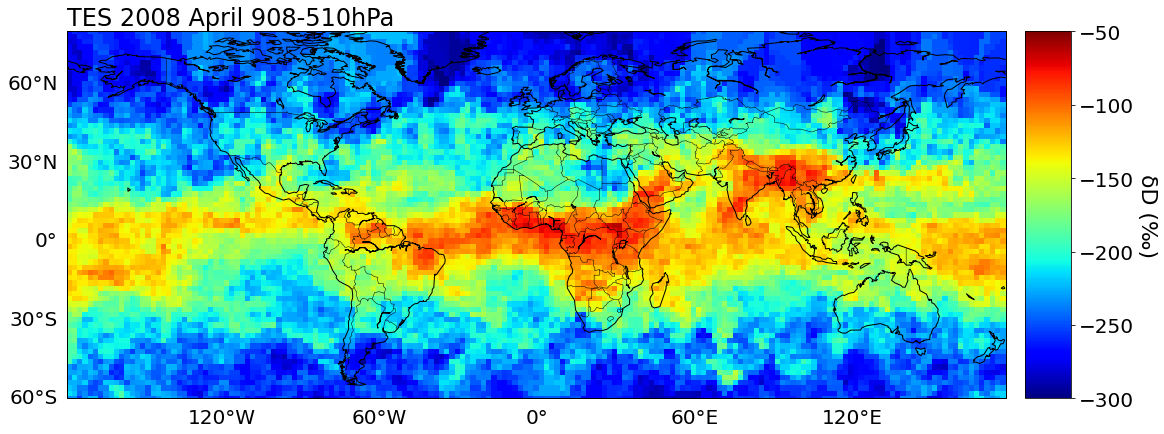

In [15]:
fig=plt.figure(figsize=(18,24),linewidth=2)
ax1 = fig.add_subplot(111)
m = Basemap(llcrnrlon=-179,llcrnrlat=-60,urcrnrlon=179,urcrnrlat=80, epsg=4326)
m.drawmapboundary(fill_color='lightcyan')
m.fillcontinents(color='snow',lake_color='lightcyan')
shade=m.pcolor(lons,lats,np.nanmean(acea_aprilm,axis=0),vmin=-300,vmax=-50,cmap=plt.cm.jet)
cbar=m.colorbar(shade)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('\u03B4D (‰)',fontsize=22,va='bottom',rotation=-90)
m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color='none', fontsize=20)
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color='none', fontsize=20)
m.drawcoastlines()
m.drawcountries()
ax1.set_title('TES 2008 April 908-510hPa', loc='left',fontsize=24)